In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import numpy as np

In [2]:
# Worldometers started reporting states on March 18th
# https://web.archive.org/web/20200318051839/https://www.worldometers.info/coronavirus/country/us/
url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv"

df = pd.read_csv(url)

In [3]:
df.tail()

,date,state,fips,cases,deaths
4244,2020-05-18,Virginia,51,31140,1014
4245,2020-05-18,Washington,53,19838,1020
4246,2020-05-18,West Virginia,54,1502,68
4247,2020-05-18,Wisconsin,55,12722,459
4248,2020-05-18,Wyoming,56,766,10


In [4]:
df["datetime"] = pd.to_datetime(df.date)
df = df.sort_values(by="datetime")

In [5]:
df.to_csv("data/nytimes.csv", index=False)

In [6]:
df.groupby("datetime").sum()["cases"]

datetime
2020-01-21          1
2020-01-22          1
2020-01-23          1
2020-01-24          2
2020-01-25          3
               ...   
2020-05-14    1424734
2020-05-15    1450963
2020-05-16    1474612
2020-05-17    1493611
2020-05-18    1515373
Name: cases, Length: 119, dtype: int64

In [7]:
def log_line(x, y):
    assert len(x) == len(y)
    run = x[-1] - x[0]
    mul_rate = (np.log2(y[-1]) - np.log2(y[0])) / run
    return 1 / mul_rate
    

In [8]:
def log_sigmoid(x, rate, offset, total, min=1):
    y = total / (1 + 2**(-(x - offset) / rate)) + min
    return y

def sigmoid(x, rate, offset, total, min=1):
    y = total / (1 + 2**(-(x - offset) / rate)) + min
    return y

In [9]:
import numpy as np

pops = pd.read_html("static-data/population.html")[0]
pops.set_index("State", inplace=True)
pops = pops["Population estimate, July 1, 2019[2]"]

df["rate"] = np.nan
for state in df.state.unique():
    idx = df.state == state
    if "princess" in state.lower():
        continue
    if "Virgin" in state:
        state = "U.S. Virgin Islands"
    if "US" in state:
        continue
    if state not in pops:
        continue
    df.loc[idx, "rate"] = df.loc[idx, "cases"] / (pops[state] / 1e6)

In [10]:
abbrvs = pd.read_csv("https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/state-abbrevs.csv")
abbrvs = {state: abbrv.item() for state, abbrv in abbrvs.set_index("state").iterrows()}

In [11]:
def state_plot(states):
    fig, ax = plt.subplots()
    for k, state in enumerate(states):
        show = df[df.state == state]
        print(state, len(show))
        d = 6
        _cases_fit = show[show.datetime >= datetime.now() - timedelta(d)]
        y = _cases_fit.cases.values
        x = (_cases_fit.datetime - _cases_fit.datetime.min()).dt.total_seconds() / (3600 * 24)
        x = x.values + 0
        rate = log_line(x, y)
        dates = [_cases_fit.datetime.min() + timedelta(int(_)) for _ in x]
        y_show = y[0] * (2 ** (x / rate))
        _cases = 2**(7 / rate)
        _ = ax.plot(show.datetime, show.rate, f"C{k}.-", label=f"{abbrvs[state]} ({_cases:0.1f}$\\times$)")#, zorder=100)
        _ = ax.plot(dates, y_show / (pops[state] / 1e6), "C7--", linewidth=2)
        print((y_show / (pops[state] / 1e6)).max())

    if "Wisconsin" in states:
        _days = (show.datetime - datetime(2020, 3, 9)).dt.total_seconds() / (3600 * 24)
        rate = 2.4
        _y = 2 ** (_days / rate)
        _y *= 1.5
        _cases = 2**(7 / rate)
        print(_y.max())
        _k = states.index("Wisconsin")
        print(_k)
        ax.plot(show.datetime, _y, f"C{_k}--", label=f"({_cases:0.1f}×)")


    xlim = (datetime(2020, 3, 9), datetime.now() + timedelta(3))
    ax.set_xlim(*xlim)
    ax.set_ylim(2, df.rate.max() * 1)

    # ax.set_ylim(0.5 * 2**12, 2 * 2**15)
    # ax.set_xlim(datetime(2020, 3, 17), None)

    ax.set_yscale("log", basey=10)
    ax.legend(loc="upper left", title="State (cases in 7 days)")
    # ax.legend(loc="upper left", title="State (cases in 7 days)")
    ax.grid(alpha=0.8)
    # ax.grid(which="minor", axis="y", alpha=0.3)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b.\n%d"))
    ax.set_ylabel("Total cases per million")
    ax.yaxis.set_major_locator(plt.FixedLocator([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10_000, 20_000, 50_000, 100_000, 200_000]))

    def thousands_sep(x, _):
        return f'{int(x):,}'

    ax.yaxis.set_major_formatter(plt.FuncFormatter(thousands_sep))
    ax.text(xlim[1] - timedelta(9), ax.get_ylim()[0] * 0.15, "© Scott Sievert", alpha=0.3)
    ax.set_title("State infection rates")
    return fig, ax

New York 79
18314.281894199205
Michigan 70
5192.12400858448
Washington 119
2605.158076416833
Wisconsin 104
2184.99685870205
Minnesota 74
2904.6221455584323
903925835.3418624
3


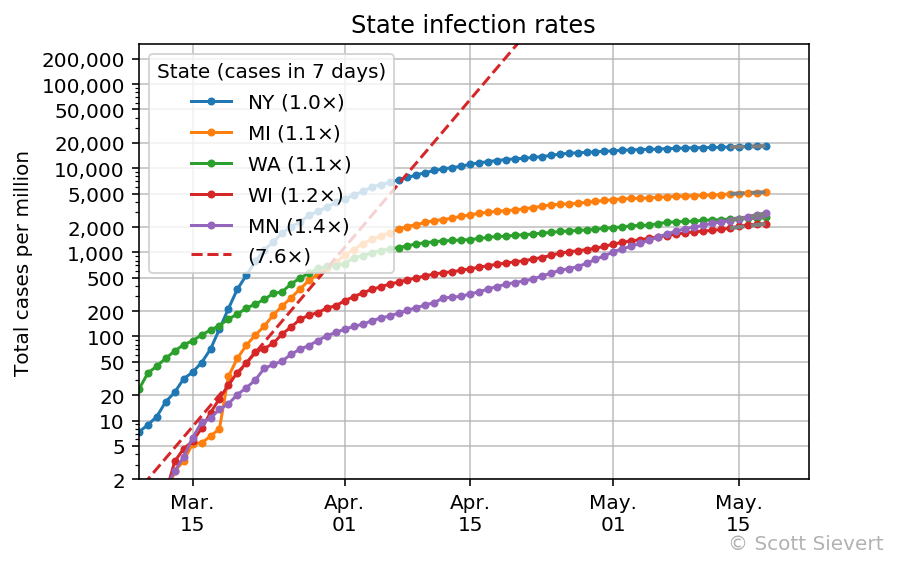

In [12]:
to_show = [
    "New York",
    "Michigan",
    "Washington",
    "Wisconsin",
    "Minnesota",
#     "Florida",
#     "New Jersey",
#     "Iowa",
#     "Colorado",
]

fig, ax = state_plot(to_show)
# fig.savefig("imgs/us-states-hist.svg", bbox_inches="tight")
# fig.savefig("imgs/us-states-hist.png", bbox_inches="tight", dpi=300)

New York 79
18314.281894199205
New Jersey 76
16666.94812878356
Colorado 75
3850.497748116945
Florida 79
2161.9596142740734
Iowa 72
4739.98992098432


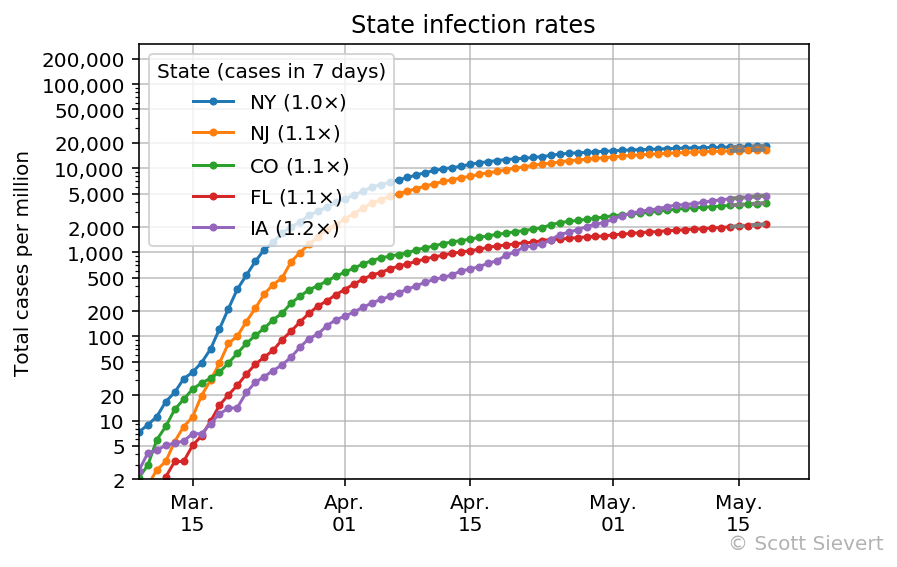

In [13]:
to_show = [
#     "Washington",
#     "Minnesota",
#     "Wisconsin",
#     "Florida",
    "New York",
#     "Michigan",
    "New Jersey",
    "Colorado",
    "Florida",
    "Iowa",
]

fig, ax = state_plot(to_show)
# fig.savefig("imgs/us-states-hist-more.svg", bbox_inches="tight")
# fig.savefig("imgs/us-states-hist-more.png", bbox_inches="tight", dpi=300)

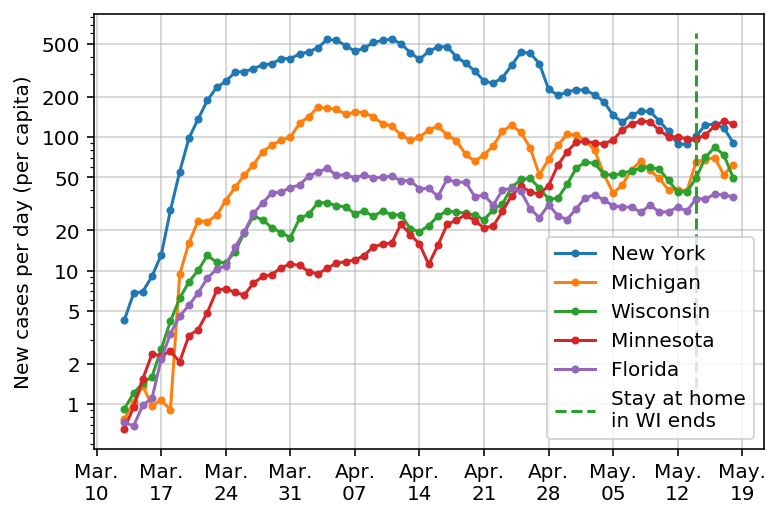

In [14]:

def show_diff_plot(to_show):
    fig, ax = plt.subplots()
    start = datetime(2020, 3, 10)
    for state in to_show:
        idx = (df.state == state) & (df.datetime >= start)
        show = df[idx].copy()

        avg = show.rate.rolling(3).mean()
        new_per_capita = avg.diff()

        ax.plot(show.datetime, new_per_capita, ".-", label=state)
    ax.set_yscale("log")
    ax.legend(loc="best")
    weeks = [start + timedelta(k * 7) for k in range(52)]
    ax.xaxis.set_major_locator(plt.FixedLocator([mdates.date2num(_) for _ in weeks]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b.\n%d"))
    ax.set_ylabel("New cases per day (per capita)")
    ax.yaxis.set_major_locator(plt.FixedLocator([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10_000, 20_000, 50_000, 100_000, 200_000]))

    def thousands_sep(x, _):
        return f'{int(x):,}'

    ax.yaxis.set_major_formatter(plt.FuncFormatter(thousands_sep))
    ax.grid(alpha=0.6)
    return fig, ax

to_show = [
    "New York",
    "Michigan",
    "Wisconsin",
    "Minnesota",
    "Florida",
#     "Colorado",
#     "Washington",
#     "Iowa",
#     "New Jersey",
]

fig, ax = show_diff_plot(to_show)
d = mdates.date2num(datetime(2020, 5, 14))
ax.plot([d, d], [1, 600], "C2--", label="Stay at home\nin WI ends")
ax.legend(loc="best")


fig.savefig("imgs/us-states-hist.svg", bbox_inches="tight")
fig.savefig("imgs/us-states-hist.png", bbox_inches="tight", dpi=300)

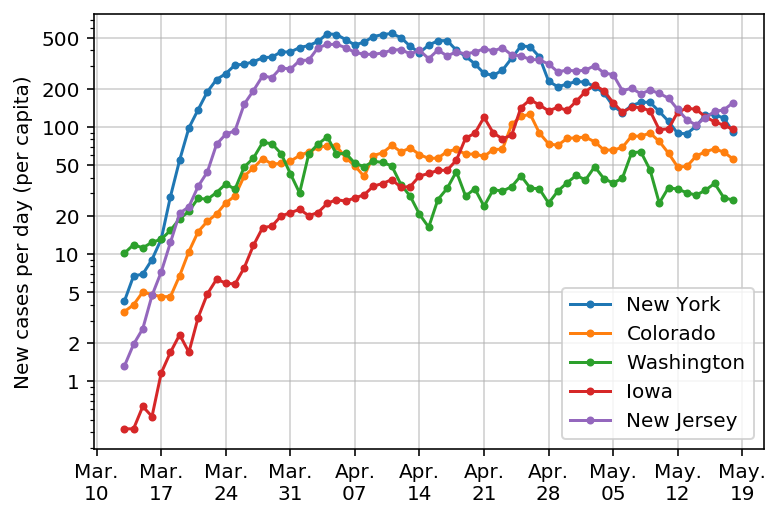

In [15]:
to_show = [
    "New York",
#     "Michigan",
#     "Wisconsin",
#     "Minnesota",
#     "Florida",
    "Colorado",
    "Washington",
    "Iowa",
    "New Jersey",
]

show_diff_plot(to_show)
fig.savefig("imgs/us-states-hist-more.svg", bbox_inches="tight")
fig.savefig("imgs/us-states-hist-more.png", bbox_inches="tight", dpi=300)

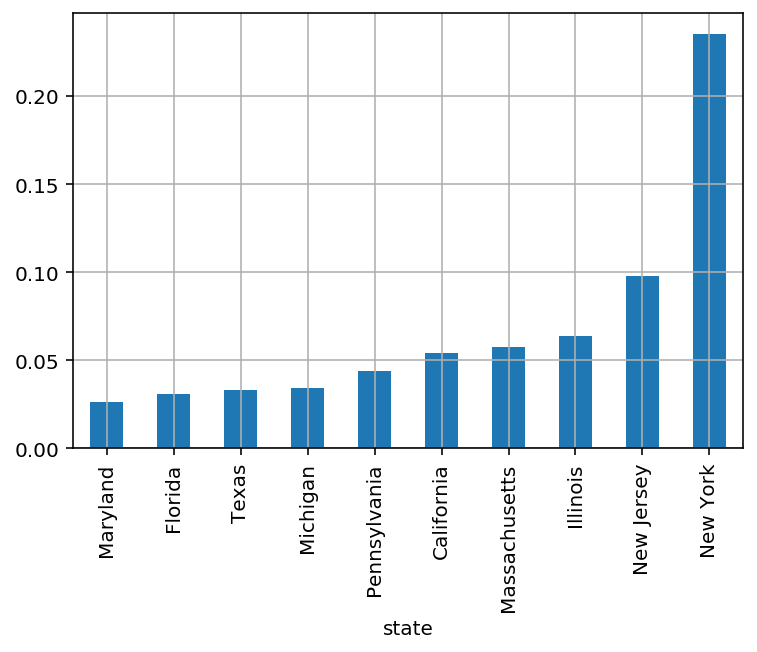

In [16]:
state_cases = df.groupby("state")["cases"].max()
state_cases.sort_values(inplace=True)
state_cases /= state_cases.sum()
ax = state_cases[-10:].plot.bar()
ax.grid()

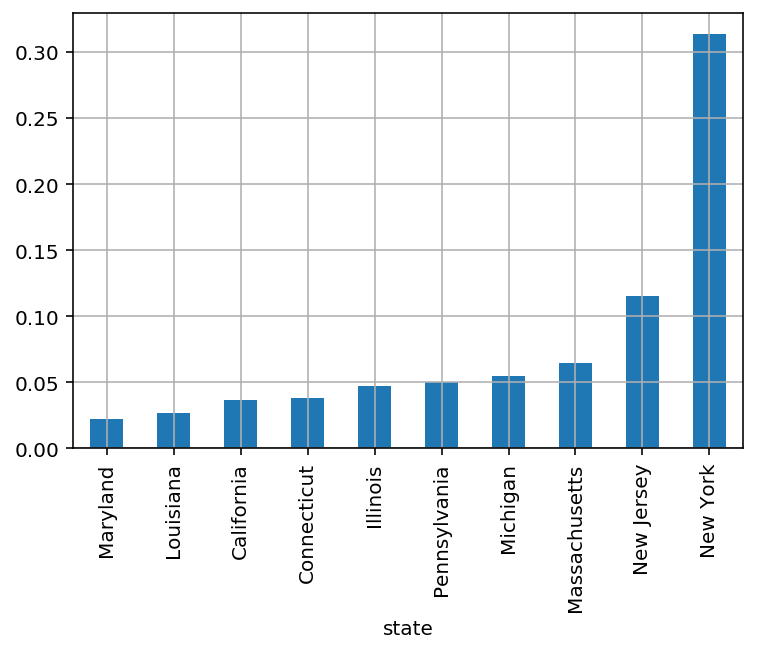

In [17]:
state_cases = df.groupby("state")["deaths"].max()
state_cases.sort_values(inplace=True)
state_cases /= state_cases.sum()
ax = state_cases[-10:].plot.bar()
ax.grid()

DatetimeIndex(['2020-01-26', '2020-02-02', '2020-02-09', '2020-02-16',
               '2020-02-23', '2020-03-01', '2020-03-08', '2020-03-15',
               '2020-03-22', '2020-03-29', '2020-04-05', '2020-04-12',
               '2020-04-19', '2020-04-26', '2020-05-03', '2020-05-10',
               '2020-05-17', '2020-05-24', '2020-05-31', '2020-06-07',
               '2020-06-14', '2020-06-21', '2020-06-28', '2020-07-05',
               '2020-07-12', '2020-07-19'],
              dtype='datetime64[ns]', freq='W-SUN')


Text(2020-05-14 18:59:50.427857, 7, '© Scott Sievert')

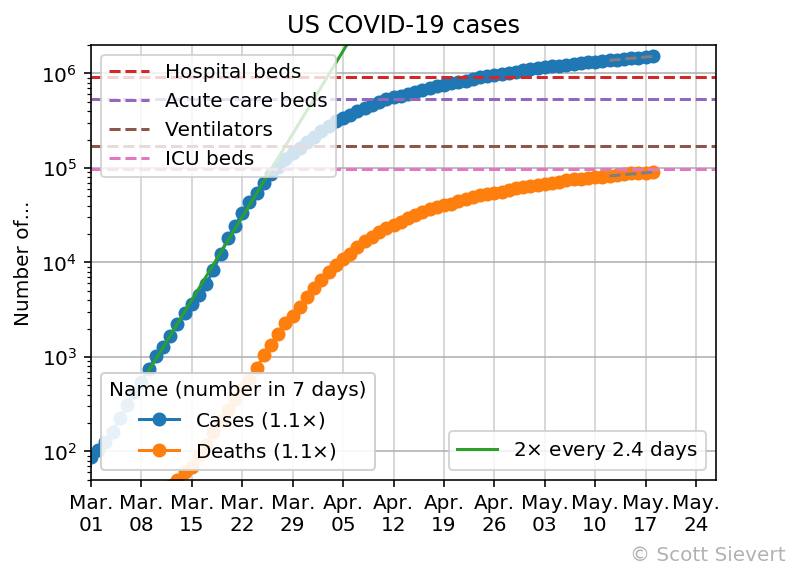

In [18]:
meta = {
    "Hospital beds": 924100,
    "Acute care beds": 534964,
    "Ventilators": 168900,  # https://www.washingtonpost.com/health/2020/03/13/coronavirus-numbers-we-really-should-be-worried-about/
    "ICU beds": 96596,
    "hospitalization_rate": 0.1,  # https://twitter.com/LizSpecht/status/1236095180459003909
}  # https://www.sccm.org/Blog/March-2020/United-States-Resource-Availability-for-COVID-19

# exclude = ["New York"]
exclude = []
us = df[~df.state.isin(exclude)].pivot_table(
    index="datetime",
    values=["cases", "deaths"],
    aggfunc="sum",
)

w = 4
fig, ax = plt.subplots(figsize=(1.4 * w, w))

lines = []
for col in ["cases", "deaths"]:
    d = 8
    _fit = us[us.index >= datetime.now() - timedelta(d)]
    _fit = _fit.groupby("datetime").sum()
    y = _fit[col].values
    x = (_fit.index - _fit.index.min()).total_seconds() / (3600 * 24)
    x = x.values + 0
    assert len(x) == len(y)
    rate = log_line(x, y)
    dates = [_fit.index.min() + timedelta(int(_)) for _ in x]

    y_show = y[0] * (2 ** (x / rate))
    _cases = 2**(7 / rate)
    line,  = ax.plot(us.index.values, us[col].values, "o-", label="{} ({:0.1f}$\\times$)".format(col.capitalize(), _cases))
    _ = ax.plot(dates, y_show, "C7--")
    lines.append(line)
legend1 = ax.legend(loc="lower left", handles=lines, framealpha=0.9, title="Name (number in 7 days)")
ax.add_artist(legend1)
xlim = (datetime(2020, 3, 1), datetime.now() + timedelta(7))
ax.set_xlim(*xlim)
ax.set_ylim(50, 2e6)#us.cases.max() * 2)

start = datetime(2020, 3, 9)
x = np.arange(50)
dates = [start + timedelta(int(d)) for d in x]
rate = 2.4
y = 0.95 * us[us.index >= start].cases.min() * 2 ** (x / rate)
line, = ax.plot(dates, y, label="2$\\times$ every 2.4 days")
legend2 = ax.legend(loc="lower right", handles=[line])
ax.add_artist(legend2)

# xlim = ax.get_xlim()
meta_lines = []
for label, num in meta.items():
    if "_" in label:
        continue
    line, = ax.plot(xlim, [num, num], "--", label=label)
    meta_lines.append(line)
ax.legend(loc="upper left", handles=meta_lines)
ax.set_xlim(*xlim)

ax.set_yscale("log")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b.\n%d"))
ax.grid(alpha=0.6)
ax.set_ylabel("Number of...")
# ax.grid(which="minor", axis="y", alpha=0.3)
ax.grid(which="major", axis="y", alpha=1.0)
ax.set_title("US COVID-19 cases")
weeks = pd.date_range(start=df.datetime.min(), end=df.datetime.min() + timedelta(days=30 * 6), freq="1W")
print(weeks)
weeks_mpl = [mdates.date2num(w) for w in weeks]
ax.xaxis.set_major_locator(plt.FixedLocator(weeks_mpl))
ax.text(xlim[1] - timedelta(12), 7, "© Scott Sievert", alpha=0.3)
# fig.savefig("us.svg", bbox_inches="tight")
# fig.savefig("us.png", bbox_inches="tight", dpi=300)

{'Hospital beds': 924100, 'Acute care beds': 534964, 'Ventilators': 168900, 'ICU beds': 96596, 'hospitalization_rate': 0.1}
0.011826950933565455
{'Hospital beds': 913170.7146422921, 'Acute care beds': 528637.007020776, 'Ventilators': 166902.42798732079, 'ICU beds': 95453.5638476213, 'hospitalization_rate': 0.09881730490664346}
DatetimeIndex(['2020-01-26', '2020-02-02', '2020-02-09', '2020-02-16',
               '2020-02-23', '2020-03-01', '2020-03-08', '2020-03-15',
               '2020-03-22', '2020-03-29', '2020-04-05', '2020-04-12',
               '2020-04-19', '2020-04-26', '2020-05-03', '2020-05-10',
               '2020-05-17', '2020-05-24', '2020-05-31', '2020-06-07',
               '2020-06-14', '2020-06-21', '2020-06-28', '2020-07-05',
               '2020-07-12', '2020-07-19'],
              dtype='datetime64[ns]', freq='W-SUN')


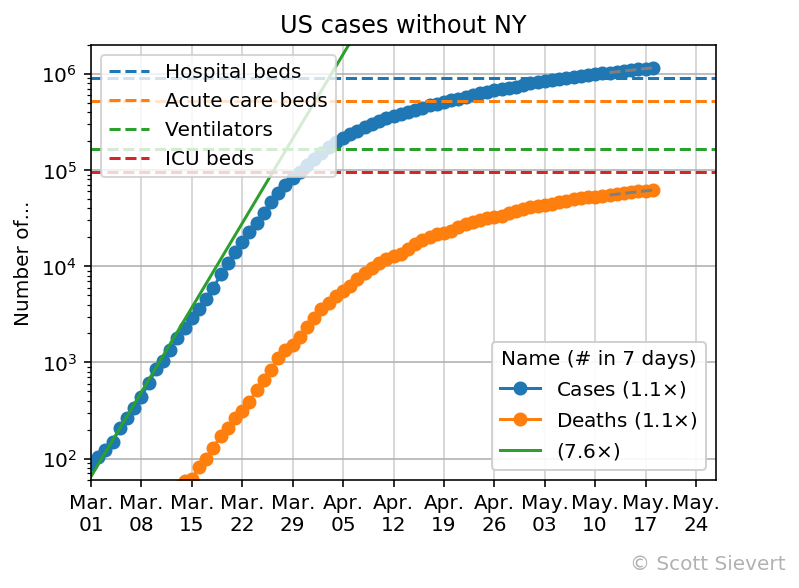

In [19]:
meta = {
    "Hospital beds": 924100,
    "Acute care beds": 534964,
    "Ventilators": 168900,  # https://www.washingtonpost.com/health/2020/03/13/coronavirus-numbers-we-really-should-be-worried-about/
    "ICU beds": 96596,
    "hospitalization_rate": 0.1,  # https://twitter.com/LizSpecht/status/1236095180459003909
}  # https://www.sccm.org/Blog/March-2020/United-States-Resource-Availability-for-COVID-19

exclude = ["New York"]

print(meta)
factor = pops[exclude].sum() / pops.sum()
print(factor)
for k in meta:
    assert 0 <= factor <= 1 and isinstance(factor, float)
    meta[k] *= (1 - factor)
print(meta)

# exclude = []
us = df[~df.state.isin(exclude)].pivot_table(
    index="datetime",
    values=["cases", "deaths"],
    aggfunc="sum",
)

w = 4
fig, ax = plt.subplots(figsize=(1.4 * w, w))

lines = []
for col in ["cases", "deaths"]:
    d = 8
    _fit = us[us.index >= datetime.now() - timedelta(d)]
    _fit = _fit.groupby("datetime").sum()
    y = _fit[col].values
    x = (_fit.index - _fit.index.min()).total_seconds() / (3600 * 24)
    x = x.values + 0
    assert len(x) == len(y)
    rate = log_line(x, y)
    dates = [_fit.index.min() + timedelta(int(_)) for _ in x]

    y_show = y[0] * (2 ** (x / rate))
    line,  = ax.plot(us.index.values, us[col].values, "o-", label="{} ({:0.1f}$\\times$)".format(col.capitalize(), 2**(7 / rate)))
    _ = ax.plot(dates, y_show, "C7--")
    lines.append(line)
xlim = (datetime(2020, 3, 1), datetime.now() + timedelta(7))
ax.set_xlim(*xlim)
ax.set_ylim(60, 2e6)#us.cases.max() * 2)

start = datetime(2020, 3, 1)
x = np.arange(50)
dates = [start + timedelta(int(d)) for d in x]
rate = 2.4
y = 0.75 * us[us.index >= start].cases.min() * 2 ** (x / rate)
line, = ax.plot(dates, y, label="({:0.1f}$\\times$)".format(2**(7 / rate)))
lines.append(line)
legend1 = ax.legend(loc="lower right", handles=lines, framealpha=0.9, title="Name (# in 7 days)")
ax.add_artist(legend1)

# xlim = ax.get_xlim()
meta_lines = []
for k, (label, num) in enumerate(meta.items()):
    if "_" in label:
        continue
    line, = ax.plot(xlim, [num, num], f"C{k}--", label=label)
    meta_lines.append(line)
ax.legend(loc="upper left", handles=meta_lines)
ax.set_xlim(*xlim)

ax.set_yscale("log")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b.\n%d"))
ax.grid(alpha=0.6)
ax.set_ylabel("Number of...")
# ax.grid(which="minor", axis="y", alpha=0.3)
ax.grid(which="major", axis="y", alpha=1.0)
ax.set_title("US cases without NY")
weeks = pd.date_range(start=df.datetime.min(), end=df.datetime.min() + timedelta(days=30 * 6), freq="1W")
print(weeks)
weeks_mpl = [mdates.date2num(w) for w in weeks]
ax.xaxis.set_major_locator(plt.FixedLocator(weeks_mpl))
ax.text(xlim[1] - timedelta(12), 7, "© Scott Sievert", alpha=0.3)
fig.savefig("imgs/us-wo-ny.svg", bbox_inches="tight")
fig.savefig("imgs/us-wo-ny.png", bbox_inches="tight", dpi=300)